In [4]:
# TODOS:
# put these todos in a more central place
# probably a good idea to sort the todos based on priority for MVP
# - improve letter grade normalized rating codes
# - ability to upload excel file for private ticks
# - constraints for generating graph
# - caching tick files for multiple runs and graph generations
# - improve date x axis labeling
# - provide key for colors
# - get running in production
# - advertise on MP forums & reddit
# - add bouldering and ice 


%matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy 
import datetime
import math

Using matplotlib backend: module://matplotlib_inline.backend_inline


In [7]:
FILENAME = 'ticks.csv'
df = pd.read_csv(FILENAME)

In [67]:
#HOW to get grade conversion
pd.options.display.max_rows = 83
print(df[['Rating Code', 'Rating']].sort_values(by='Rating Code').drop_duplicates())

     Rating Code     Rating
623            0  Easy Snow
73           800        3rd
489          900        4th
437          950   Easy 5th
579         1000        5.0
..           ...        ...
127        32250       WI3+
455        32500      WI3-4
458        33000        WI4
456        33250       WI4+
452        33500    WI4-5 X

[82 rows x 2 columns]


In [76]:
## JUPYTER NOTES
# df[ df['Route Type'].str.contains('^TR')] # Filter by regex
# route_types = df['Route Type'].unique() # get unique col values
# df.loc[df['Route Type'].str.contains('Trad') & (df['Rating Code'].between(0, 1500))] # multiple filters (Trad routes & grade)
# df.loc[df['Style']=='Solo'].sort_values(by='Date')
# df.loc[df['Rating'].str.contains('R')]

,Date,Route,Rating,Notes,URL,Pitches,Location,Avg Stars,Your Stars,Style,Lead Style,Route Type,Your Rating,Length,Rating Code
63,2024-04-11,Risky Business,5.10c R,Led P2 5.10b + p4. So happy to get on this,https://www.mountainproject.com/route/10573286...,4,Nevada > Southern Nevada > Red Rocks > (10) Pi...,3.8,-1,Lead,Flash,Trad,5.10 PG13,400.0,3200
89,2024-03-13,Caver's Route,5.3 R,Pure joy,https://www.mountainproject.com/route/10588202...,4,Kentucky > Red River Gorge > Northern Gorge > ...,3.6,4,Lead,Flash,Trad,NaN,200.0,1300
136,2023-12-26,Immelman Direct,5.10+ R,Hard Boulder & heady finish,https://www.mountainproject.com/route/11535571...,1,New York > Powerlinez > h. Revolutionary Rampa...,3.0,-1,Follow,NaN,"Trad, TR",NaN,55.0,3300
142,2023-12-22,Thread the Gap,5.9 R,NaN,https://www.mountainproject.com/route/11047521...,2,New York > Powerlinez > k. Tower Wall area > 4...,2.3,-1,TR,NaN,"Trad, TR",NaN,50.0,2400
143,2023-12-22,Hot Porridge,5.6 R,NaN,https://www.mountainproject.com/route/12049678...,2,New York > Powerlinez > k. Tower Wall area > 5...,2.4,-1,TR,NaN,"Trad, TR",NaN,85.0,1600
189,2023-12-02,Caliban,5.8+ R,NaN,https://www.mountainproject.com/route/10573296...,1,Nevada > Southern Nevada > Red Rocks > (01) Ca...,1.5,2,NaN,NaN,Sport,NaN,60.0,2200
190,2023-12-02,Front Side Crack,5.8 V0 R,Night send,https://www.mountainproject.com/route/10661779...,1,Nevada > Southern Nevada > Red Rock Boulders >...,3.7,-1,Send,NaN,Boulder,NaN,25.0,2100
223,2023-10-12,Sort of Damocles,5.8 R,“Stick clipped” R start,https://www.mountainproject.com/route/12296300...,1,New York > The Gunks > The Trapps > g. V3 - Mi...,1.7,2,Lead,Flash,Trad,NaN,100.0,2100
253,2023-09-02,No Picnic,5.6 R,NaN,https://www.mountainproject.com/route/10720798...,1,New York > Adirondacks > B: Chapel Pond Pass >...,1.7,2,TR,NaN,Trad,NaN,90.0,1600


In [8]:
style_types = ['Lead', 'Solo', 'Flash', 'Send', numpy.nan]
columns = ['Date', 'Rating Code', 'Route Type', 'Pitches', 'Style']
df = df.loc[df['Style'].isin(style_types), columns]
df = df.loc[df['Route Type'].str.contains('Trad|Sport', regex=True)]
df['Date'] = df['Date'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d").date() if type(x) == str else x)
df = df.sort_values(by='Date', ascending=True)

#TODO:
# normalize 'Rating Code' column!!
# Step function??

##
# this can possibly even be normalized more accurately by having each letter grade 250 apart. ie:
#    4600 => 4625 '5.11a',    
#    4700 => '5.11-',
#    4800 => 4800 '5.11a/b',
#    4900 => 4875 '5.11b',
#    5000 => 5000 '5.11',



def normailize_rating_code(x):
    conditions = {
        800: 1625, # '3rd'
        900: 1875, # '4th'
        950: 2000, # 'Easy 5th'
        1000: 2125, # '5.0'
        1100: 2375, # '5.1'
        1200: 2625, # '5.2'
        1300: 2875, # '5.3'
        1400: 3125, # '5.4'
        1500: 3375, # '5.5'
        1600: 3625, # '5.6'
        1800: 3875, # '5.7'
        1900: 3925, # '5.7+'
        2000: 4075, # '5.8-'
        2100: 4125, # '5.8'
        2200: 4175, # '5.8+'
        2300: 4325, # '5.9-'
        2400: 4375, # '5.9'
        2500: 4425} # '5.9+'
    if abs(3000 - x) <= 500: # 5.10
        x += 2000
    elif abs(5000 - x) <= 500: # 5.11
        x += 1000
    elif abs(9000 - x) <= 500: # 5.13
        x -= 1000
    elif abs(11000 - x) <= 500: # 5.14
        x -= 2000
    elif abs(12000 - x) <= 500: # 5.15
        x -= 2000
    else:
        x = conditions.get(x, x)
    return x

df['Normalized Rating Code'] = df['Rating Code'].apply(normailize_rating_code)

df

,Date,Rating Code,Route Type,Pitches,Style,Normalized Rating Code
728,2020-09-04,1800,Sport,1,Lead,3875
727,2020-09-05,1600,Sport,1,Lead,3625
725,2020-09-07,1800,Sport,1,NaN,3875
726,2020-09-07,1800,Sport,1,Lead,3875
717,2021-03-27,1600,Sport,1,Lead,3625
...,...,...,...,...,...,...
5,2024-05-26,2900,Sport,1,Lead,4900
4,2024-05-26,2100,Sport,1,Lead,4125
3,2024-05-26,3400,Sport,1,Lead,5400
2,2024-05-26,3400,Sport,1,Lead,5400


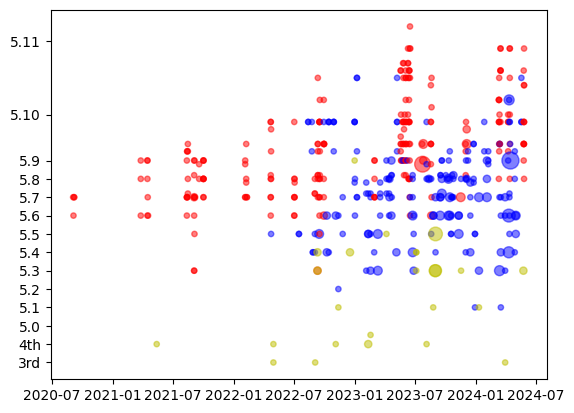

In [22]:
x = df['Date']
y = df['Normalized Rating Code']
c = df.apply(lambda x : 'y' if (x['Style'] == 'Solo') else ('r' if (x['Route Type'] == 'Sport') else 'b') , axis=1)
area = (df['Pitches'].apply(math.sqrt)/math.pi * 1.772453850905516 * 15)  #TODO: come up with better area formula for multipitch
area = (df['Pitches'].apply(lambda x : math.pow(x, 0.9)) * 15) 
plt.scatter(x, y, c=c, s=area, alpha=0.5) 


def generate_yticks(ylim_min, ylim_max):
    yticks = numpy.append(
        numpy.arange(1625, 4375+1, step=250), 
        numpy.arange(5000, 10000+1, step=1000))
    labels = numpy.array(['3rd', '4th', '5.0', '5.1', '5.2', '5.3', '5.4', '5.5', '5.6', '5.7', '5.8', '5.9', 
              '5.10', '5.11', '5.12', '5.13', '5.14', '5.15'])
    filter_arr = (ylim_min <=  yticks) & (yticks <= ylim_max)
    yticks = yticks[filter_arr]
    labels = list(labels[filter_arr])
    return yticks, labels

ylim_min, ylim_max = plt.ylim()
yticks, ylabels = generate_yticks(ylim_min, ylim_max)
plt.yticks(yticks, ylabels)


plt.savefig('tick_plot.png')
plt.show()

(1.8, 6.2)
11


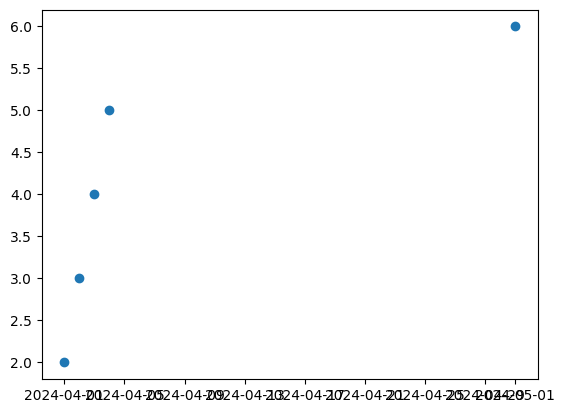

In [113]:
y=numpy.array([2,3,4,5,6])

x=numpy.array([
datetime.datetime.strptime("2024-04-01", "%Y-%m-%d").date(),
datetime.date(2024,4,2),
datetime.date(2024,4,3),
datetime.date(2024,4,4),
datetime.date(2024,5,1),
])

plt.scatter(x, y)

print(plt.ylim())
print(len(plt.yticks()[0]))

# locs, labels = plt.yticks()  # Get the current locations and labels.

# plt.yticks(numpy.arange(2, 5, step=1))  # Set label locations.

# plt.yticks(numpy.arange(0, 5000, step=1000), ['5.4', '5.6', '5.8', '5.10', '5.11'])  # Set text labels.


##Axes.set_yticklabels

plt.show()


In [40]:
#lambda x : 'y' if (x['Style'] == 'Solo') else ('r' if (x['Route Type'] == 'Sport') else 'Trad')
df.apply(lambda x : 'y' if (x['Style'] == 'Solo') else ('r' if (x['Route Type'] == 'Sport') else 'Trad') , axis=1)


728    r
727    r
725    r
726    r
717    r
      ..
5      r
4      r
3      r
2      r
1      r
Length: 455, dtype: object

In [19]:
for x in numpy.append(numpy.arange(1000, 6000, step=1000), numpy.arange(1000, 6000, step=1000)):
    print(x)

def generate_yticks(ylim_min, ylim_max):
    yticks = numpy.append(
        numpy.arange(1625, 4375+1, step=250), 
        numpy.arange(5000, 10000+1, step=1000))
    labels = numpy.array(['3rd', '4th', '5.0', '5.1', '5.2', '5.3', '5.4', '5.5', '5.6', '5.7', '5.8', '5.9', 
              '5.10', '5.11', '5.12', '5.13', '5.14', '5.15'])
    filter_arr = (ylim_min <=  yticks) & (yticks <= ylim_max)
    yticks = yticks[filter_arr]
    labels = list(labels[filter_arr])
    return yticks, labels

generate_yticks(1700, 5500)

1000
2000
3000
4000
5000
1000
2000
3000
4000
5000


(array([1875, 2125, 2375, 2625, 2875, 3125, 3375, 3625, 3875, 4125, 4375,
        5000]),
 ['4th',
  '5.0',
  '5.1',
  '5.2',
  '5.3',
  '5.4',
  '5.5',
  '5.6',
  '5.7',
  '5.8',
  '5.9',
  '5.10'])